In [1]:
import os
from dotenv import load_dotenv
load_dotenv('.env')



True

In [2]:

from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.agents import AgentAction, AgentFinish
from langchain_experimental.llms.ollama_functions import convert_to_ollama_tool
import operator
from typing import Annotated, Sequence, TypedDict, Union

from langchain_core.messages import BaseMessage

from libs.language_model import agent_runnable

class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    context: str
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction,str]], operator.add]







Loading from disk


In [3]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage, HumanMessage, AIMessage, ToolMessage
from libs.language_model import tools
from langgraph.prebuilt import ToolExecutor, ToolInvocation

tool_executor = ToolExecutor(tools)

def should_continue(state):
    print('should_continue',state)
    messages = [state["agent_outcome"]]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if "Action" not in last_message.log:
        return "end"
    # Otherwise we continue
    else:
        return "continue"

def execute_tools(state):
    print("state at execute_tools", state)
    messages = [state["agent_outcome"]]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    
    tool_name = last_message.tool
    
    print('Calling tool:',tool_name, "with arguments: ",last_message.tool_input)

    
    action = ToolInvocation(
        tool=tool_name,
        tool_input=last_message.tool_input
    )
    
    response = tool_executor.invoke(action)
    # We construct an ToolInvocation for each tool call


    # We return a list, because this will get added to the existing list
    return {"intermediate_steps":[(state["agent_outcome"], response)]}

from libs.language_model import qa_chain

def retrieval_agent(state):
    print('state at retrieval_agent',state)
    question = state["input"]
    
    response = qa_chain.invoke({"query": question})['result']
    print("Response from retrieval agent", response)
    
    ai_message = HumanMessage(content=response)
    # Append the AI message to the chat history
    new_chat_history = state["chat_history"] + [ai_message]

    return {"context": response }


def run_agent(state):
    """
    #if you want to better manages intermediate steps
    inputs = state.copy()
    if len(inputs['intermediate_steps']) > 5:
        inputs['intermediate_steps'] = inputs['intermediate_steps'][-5:]
    """
    print('State at run_agent',state)
    agent_outcome = agent_runnable.invoke(state)

    return {"agent_outcome": agent_outcome}









In [4]:
from langgraph.graph import StateGraph, END, START

# Initialize a new graph
graph = StateGraph(AgentState)

# Define the two "Nodes"" we will cycle between
graph.add_node("agent", run_agent)
graph.add_node("retriever", retrieval_agent)
graph.add_node("action", execute_tools)
# graph.add_node("rag", fetch_rag)
# Define all our "Edges"
# Set the "Starting Edge" as "agent"
# This means that this node is the first one called
graph.set_entry_point("retriever")


# We now add a "Conditional Edge"
# Conditinal agents take:
# - A start node
# - A function that determines which node to call next
# - A mapping of the output of the function to the next node to call
graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        # "retriever" : "retriever",
        # END is a special node marking that the graph should finish.
        "end": END,
    },
)




# We now add a "Normal Edge" that should always be called after another

graph.add_edge(START, "retriever")
graph.add_edge("retriever","agent")
# graph.add_edge(START, "agent")
graph.add_edge("action", "agent")

# We compile the entire workflow as a runnable
app = graph.compile()

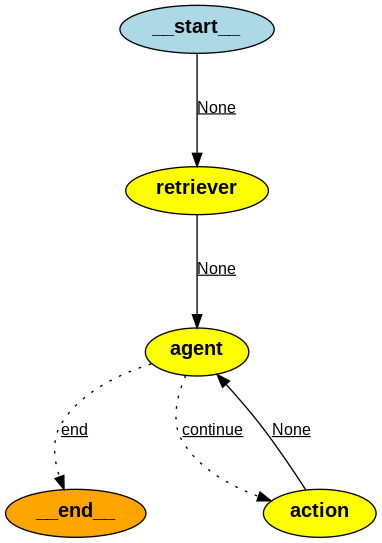

In [5]:
from IPython.display import Image, display
Image(app.get_graph().draw_png())
# display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [6]:
from langchain_core.messages import HumanMessage

# input_text = "get the unique dimension protocols from the database?"
# inputs = {"input": input_text, "chat_history": []}
inputs = {
    "input": "get the unique dimension protocols from the database", "chat_history":[]
}
for output in app.stream(inputs,{"recursion_limit":10}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

state at retrieval_agent {'input': 'get the unique dimension protocols from the database', 'chat_history': [], 'context': None, 'agent_outcome': None, 'intermediate_steps': []}
Response from retrieval agent [/INST]<<SYS>> To get the unique dimension protocols from the database, you can use the `get_unique_dimension_values` tool with the column name corresponding to the protocol dimension. This function will return a list of unique protocol values. [/SYS)>>[/INST]
Output from node 'retriever':
---
{'context': '[/INST]<<SYS>> To get the unique dimension protocols from the database, you can use the `get_unique_dimension_values` tool with the column name corresponding to the protocol dimension. This function will return a list of unique protocol values. [/SYS)>>[/INST]'}

---

State at run_agent {'input': 'get the unique dimension protocols from the database', 'chat_history': [], 'context': '[/INST]<<SYS>> To get the unique dimension protocols from the database, you can use the `get_unique